In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'
! echo $OMP_NUM_THREADS

40


In [2]:
import nawrapper as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits

In [3]:
planck_project = '/tigress/zequnl/cmb/software/PSpipe/project/Planck/'

In [4]:
pol_efficiency = {
    '100' : 0.9995,
    '143' : 0.999,
    '217' : 0.999
}

In [5]:
project_dir = '/tigress/zequnl/cmb/data/planck2018/'
map_dir = f'{project_dir}/maps/PR3/frequencyMaps'
mask_dir = f'{project_dir}/maps/PR3/maskMaps/'
beam_dir = f'{project_dir}/BeamWf_HFI_R3.01/'
nside = 2048
lmax = 2508
freq1 = '143'
freq2 = '143'
split1 = '1'
split2 = '2'

# now the specific combination m1 x m2 we want to do here
beam_Wl_hdu = fits.open(beam_dir + f'Wl_R3.01_plikmask_{freq1}hm{split1}x{freq2}hm{split2}.fits')
mfile_1 = f'{map_dir}/HFI_SkyMap_{freq1}_2048_R3.01_full-evenring.fits'
mfile_2 = f'{map_dir}/HFI_SkyMap_{freq2}_2048_R3.01_full-oddring.fits'

maskfile1 = f'{mask_dir}/COM_Mask_Likelihood-temperature-{freq1}-hm{split1}_2048_R3.00.fits'
maskfile2 = f'{mask_dir}/COM_Mask_Likelihood-temperature-{freq2}-hm{split2}_2048_R3.00.fits'
maskfile1_pol = f'{mask_dir}/COM_Mask_Likelihood-polarization-{freq1}-hm{split1}_2048_R3.00.fits'
maskfile2_pol = f'{mask_dir}/COM_Mask_Likelihood-polarization-{freq2}-hm{split2}_2048_R3.00.fits'

In [6]:
pol_fac = pol_efficiency[freq1]
beam_TT = np.sqrt(beam_Wl_hdu[1].data['TT_2_TT'][0])
beam_EE = np.sqrt(beam_Wl_hdu[2].data['EE_2_EE'][0])
beam_BB = np.sqrt(beam_Wl_hdu[3].data['BB_2_BB'][0])
beam_TE = np.sqrt(beam_Wl_hdu[4].data['TE_2_TE'][0])

In [7]:
m1_map_I, m1_map_Q, m1_map_U = hp.read_map(
    mfile_1, field=(0,1,2), verbose=False)
m2_map_I, m2_map_Q, m2_map_U = hp.read_map(
    mfile_2, field=(0,1,2), verbose=False)

mask1 = hp.read_map(maskfile1, verbose=False)
mask2 = hp.read_map(maskfile2, verbose=False)
mask1_pol = hp.read_map(maskfile1_pol, verbose=False)
mask2_pol = hp.read_map(maskfile2_pol, verbose=False)

/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [8]:
missing_pixel_1 = (m1_map_I < -1e30)
missing_pixel_2 = (m2_map_I < -1e30)

m1_map_I[missing_pixel_1] = 0.0
m1_map_Q[missing_pixel_1] = 0.0
m1_map_U[missing_pixel_1] = 0.0
m2_map_I[missing_pixel_2] = 0.0
m2_map_Q[missing_pixel_2] = 0.0
m2_map_U[missing_pixel_2] = 0.0

In [9]:
# convert from K_CMB to μK_CMB
m1_map_I *= 1e6
m1_map_Q *= 1e6 * pol_fac
m1_map_U *= 1e6 * pol_fac
m2_map_I *= 1e6
m2_map_Q *= 1e6 * pol_fac
m2_map_U *= 1e6 * pol_fac

In [10]:
m1 = nw.namap(
    map_I=m1_map_I, mask_temp=mask1, beam_temp=beam_TT, 
    map_Q=m1_map_Q, map_U=m1_map_U, mask_pol=mask1_pol, beam_pol=beam_EE,
    unpixwin=True,
    nside=nside, sub_monopole=True, sub_dipole=True)
m2 = nw.namap(
    map_I=m2_map_I, mask_temp=mask2, beam_temp=beam_TT, 
    map_Q=m2_map_Q, map_U=m2_map_U, mask_pol=mask2_pol, beam_pol=beam_EE,
    unpixwin=True,
    nside=nside, sub_monopole=True, sub_dipole=True)

Creating a healpix map. (temperature: True, polarization: True)
Multiplying beam with healpix pixel window function.
Subtracting monopole and dipole from temperature map.
Computing spherical harmonics.

Creating a healpix map. (temperature: True, polarization: True)
Multiplying beam with healpix pixel window function.
Subtracting monopole and dipole from temperature map.
Computing spherical harmonics.



In [11]:
bins = nw.get_unbinned_bins(lmax)

In [12]:
## uncomment to recompute
# mc = nw.mode_coupling(m1, m2, bins)
# mc.write_to_dir('data/143x143')
mc = nw.mode_coupling(mcm_dir='data/143x143')

In [13]:
Cb = nw.compute_spectra(m1, m2, mc=mc)

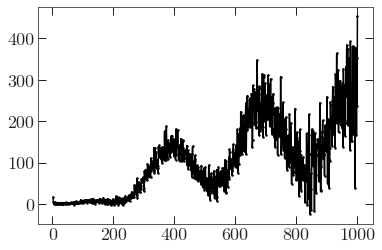

In [14]:
plt.plot(Cb['ell'][:1000], Cb['EE'][:1000] * Cb['ell'][:1000]**2)

In [15]:
Cl12 = nw.compute_spectra(m1, m2, mc=mc)
Cl11 = nw.compute_spectra(m1, m1, mc=mc)
Cl22 = nw.compute_spectra(m2, m2, mc=mc)

In [16]:
from astropy.io import ascii
th = ascii.read('data/planck/theory_cl.txt')
fg = ascii.read('data/planck/foreground_cl.txt')
fg['BB143X143'] = fg['EE143X143'] * 0.0

In [17]:
def ap(x): return np.hstack( ((0.0,0.0), x) )
ell_fac = fg['l'][:2507] * (fg['l'][:2507]+1) / (2 * np.pi)
signal_dict = {}
for XY in ['TT', 'TE', 'EE', 'BB']:
    signal_dict[XY] =  ap((th[XY] + fg[XY + '143X143'][:2507])/ell_fac)
    
signal_dict['EB'] = signal_dict['EE'] * 0.0

In [18]:
pl = nw.planck.PlanckCov(
    ellspath=f'{planck_project}/planck_spectra/vec_all_spectra.dat',
    clpath='data/planck/data_extracted.dat',
    covpath='data/planck/covmat.dat'
    )
ell, cl, err, _  = pl.get_subcov('TT_143x143', debug=True)

TT_143x143 136 335


In [19]:
binleft, binright = np.genfromtxt(
    '/tigress/zequnl/cmb/software/PSpipe/project/Planck/planck_spectra/binused.dat',
    unpack=True, usecols=(0,1), dtype=((int), (int)))

In [20]:
Cb = nw.bin_spec_dict(Cl12, binleft, binright, lmax)
Cb11 = nw.bin_spec_dict(Cl11, binleft, binright, lmax)
Cb22 = nw.bin_spec_dict(Cl22, binleft, binright, lmax)

TT_143x143 136 335
TE_143x143 1810 2009
EE_143x143 1048 1247


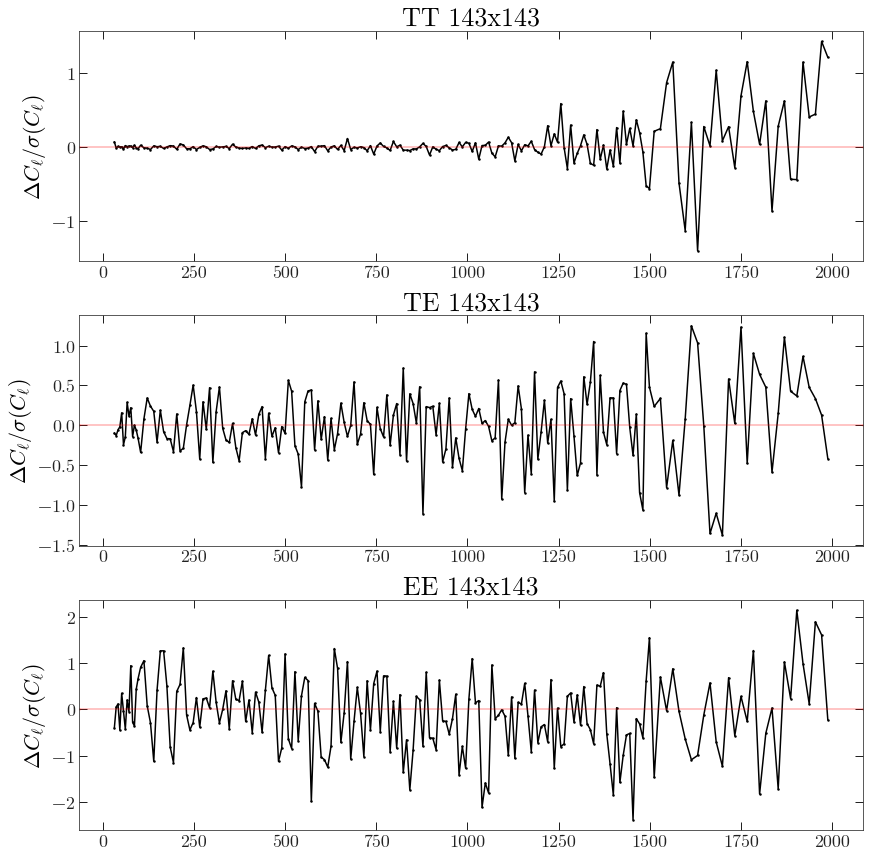

In [21]:
fig, axes = plt.subplots(3,1,figsize=(12,12))
for ax, spec in zip(axes, ['TT', 'TE', 'EE']):
    lb = Cb['ell']
    
    ell, cl, err, subcov  = pl.get_subcov(
        f'{spec}_{freq1}x{freq2}', debug=True)
    dl_ref_fac = ell*(ell+1)/(2*np.pi)
    ref_filt = np.in1d(lb, ell)
    if spec == 'TE':
        diy_spec = (Cb['TE'][ref_filt] + Cb['ET'][ref_filt])/ 2.0
    else:
        diy_spec = Cb[spec][ref_filt]
    ax.plot(ell, (diy_spec - (cl)) / (err), 'k.-', label=spec)
    ax.axhline(0, color='red', alpha=0.3)
    ax.set_ylabel(r'$\Delta C_{\ell} / \sigma(C_{\ell})$')
    ax.set_title(f'{spec} {freq1}x{freq2}')
plt.tight_layout()

In [22]:
# plt.plot(Cl12['ell'], Cl12['TT'])

# l, dl = np.genfromtxt('bestfit.txt', unpack=True, usecols=(0,1))
# cl = dl / (l * (l+1)) * np.pi * 2
# plt.plot(l, cl)
# plt.yscale('log')

In [23]:
# plt.plot(Cl12['TT'] / cl)
# plt.ylim(-2,3)
# # plt.yscale('log')

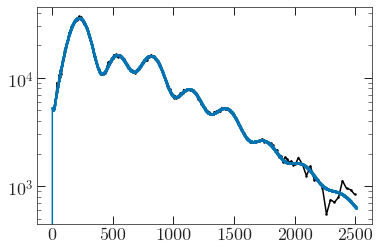

In [24]:
plt.plot(lb, Cb['TT'] * lb**2)
plt.plot( signal_dict['TT'] * np.arange(2509)**2)
plt.yscale('log')

In [25]:
# from scipy.signal import savgol_filter
# nl_tt = ap( savgol_filter( (Cl11['TT'] + Cl22['TT'])/2.0 - Cl12['TT'], 21, 3))
# nl_ee = ap( (Cl11['EE'] + Cl22['EE'])/2.0 - Cl12['EE'] )

In [26]:
noise_dict = {}
for k in signal_dict:
    if 'B' in k:
        signal_dict[k] *= 0.0
        noise_dict[k] = signal_dict[k]

In [28]:
cov = nw.nacov(m1, m2, mc, signal=signal_dict, noise=noise_dict)

Assuming EB signal is zero.


In [29]:
ring_diff = nw.namap(
    map_I=m1_map_I - m2_map_I, 
    mask_temp=np.minimum(mask1, mask2), 
    beam_temp=beam_TT, 
    map_Q=m1_map_Q - m2_map_Q, map_U=m1_map_U - m2_map_U, 
    mask_pol=np.minimum(mask1_pol, mask2_pol), beam_pol=beam_EE,
    unpixwin=True,
    nside=nside, sub_monopole=True, sub_dipole=True)

Creating a healpix map. (temperature: True, polarization: True)
Multiplying beam with healpix pixel window function.
Subtracting monopole and dipole from temperature map.
Computing spherical harmonics.



In [30]:
Cb_noise = nw.compute_spectra(ring_diff, ring_diff, mc=mc)

(0, 3)

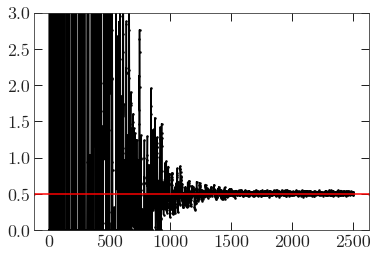

In [32]:
plt.plot(cov.noise['TT'][2:] / Cb_noise['TT'])
plt.axhline(1/2, color='r')
plt.ylim(0,3)

In [57]:
n_ell = len(bins.get_effective_ells())
ell_cov, cl, err, cov_plic = pl.get_subcov('TT_143x143', debug=True)

TT_143x143 136 335


Text(0.5, 0, 'Multipole $\\ell$')

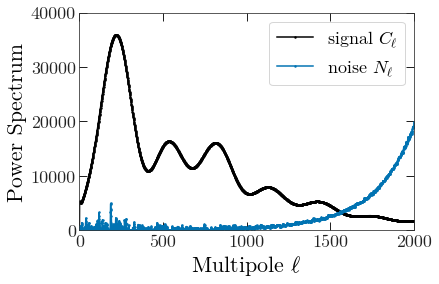

In [58]:
plt.figure(figsize=(6,4))
plt.plot(cov.signal['TT'] * np.arange(2509)**2, label="signal $C_{\ell}$")
plt.plot(cov.noise['TT'] * np.arange(2509)**2, label="noise $N_{\ell}$")
# plt.yscale('log')
plt.xlim(0,2000)
plt.ylim(0,40000)
plt.legend()
plt.ylabel(r'Power Spectrum')
plt.xlabel(r'Multipole $\ell$')

(0.0, 0.05)

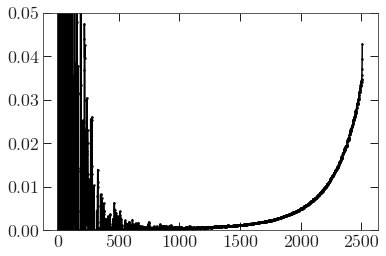

In [59]:
from scipy.signal import savgol_filter as sf

plt.plot( cov.noise['TT'])
plt.ylim(0.0, 0.05)

# plt.yscale('log')

Text(0.5, 0, 'Multipole $\\ell$')

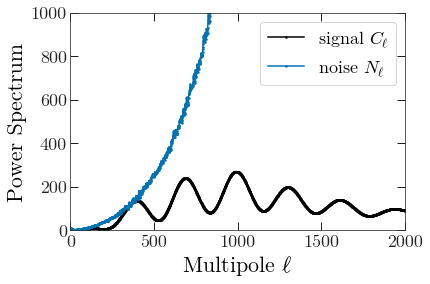

In [60]:
plt.figure(figsize=(6,4))
plt.plot(cov.signal['EE'] * np.arange(2509)**2, label="signal $C_{\ell}$")
plt.plot(cov.noise['EE'] * np.arange(2509)**2, label="noise $N_{\ell}$")
# plt.yscale('log')
plt.xlim(0,2000)
plt.ylim(0,1000)
plt.legend()
plt.ylabel(r'Power Spectrum')
plt.xlabel(r'Multipole $\ell$')

In [ ]:
%%time
cov.compute(m1, m2, mc)

In [ ]:
ell_sub_list = [np.arange(l, r) for (l, r) in zip(binleft, binright+1)]

binned_cov = np.zeros((len(ell_sub_list), len(ell_sub_list)))
lb = np.array([ (l+r)/2.0 for l,r in zip(binleft, binright) ])
for i, (bin_i) in enumerate( zip(binleft, binright+1) ):
    for j, (bin_j) in enumerate( zip(binleft, binright+1) ):
        binned_cov[i,j] = np.mean( cov.covar_TT_TT[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] )

plt.plot(lb, np.diag(binned_cov) * lb**4, label='analytic')
plt.plot( ell_cov, np.diag(cov_plic) * ell_cov**4, label="extracted plic cov" )
plt.yscale('log')
plt.legend()

In [ ]:
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) / pixwin_T[l.astype(int)]**4 )
plt.plot( ell_cov, np.sqrt( np.diag(binned_cov)[:199] / np.diag(cov_plic) ), label='TT diag zack / diag plic' )
plt.legend()
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) * pixwin_T[l.astype(int)]**4 )
# plt.ylim(0.0, 1.0)
plt.ylabel(r'$\sigma$')
plt.gca().axhline(1.0,ls='--')

In [ ]:
n_ell = len(bins.get_effective_ells())
ell_cov, cl, err, cov_plic = pl.get_subcov('EE_143x143', debug=True)

In [ ]:
ell_sub_list = [np.arange(l, r) for (l, r) in zip(binleft, binright+1)]

binned_cov = np.zeros((len(ell_sub_list), len(ell_sub_list)))
lb = np.array([ (l+r)/2.0 for l,r in zip(binleft, binright) ])
for i, (bin_i) in enumerate( zip(binleft, binright+1) ):
    for j, (bin_j) in enumerate( zip(binleft, binright+1) ):
        binned_cov[i,j] = np.mean( cov.covar_EE_EE[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] )

plt.plot( ell_cov, np.sqrt(np.diag(cov_plic)) * ell_cov**2, label="extracted plic cov" )

plt.plot(lb[lb < ell_cov[-1]], 
         (np.sqrt(np.diag(binned_cov)) * lb**2)[lb < ell_cov[-1]], label='analytic')

plt.legend()

In [ ]:
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) / pixwin_T[l.astype(int)]**4 )
plt.plot( ell_cov, np.sqrt(np.diag(binned_cov)[:199] / np.diag(cov_plic) ), label='EE diag zack / diag plic' )
plt.legend()
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) * pixwin_T[l.astype(int)]**4 )
# plt.ylim(0.0, 1.0)
plt.gca().axhline(1.0,ls='--')

In [ ]:
# covar_22_22 = nmt.gaussian_covariance(
#             cov.cw, 2, 2, 2, 2,  # Spins of the 4 fields
#             [cov.signal['EE']+cov.noise['EE'], 0.0 * cov.signal['EB'],
#              0.0 * cov.signal['EB'], 0.0 * cov.signal['BB']],  # EE, EB, BE, BB
#             [cov.signal['EE'], 0.0 * cov.signal['EB'],
#              0.0 * cov.signal['EB'], 0.0 * cov.signal['BB']],  # EE, EB, BE, BB
#             [cov.signal['EE'], 0.0 * cov.signal['EB'],
#              0.0 * cov.signal['EB'], 0.0 * cov.signal['BB']],  # EE, EB, BE, BB
#             [cov.signal['EE']+cov.noise['EE'], 0.0 * cov.signal['EB'],
#              0.0 * cov.signal['EB'], 0.0 * cov.signal['BB']],  # EE, EB, BE, BB
#             cov.mc.w22, wb=cov.mc.w22).reshape([cov.num_ell, 4,
#                                   cov.num_ell, 4])

In [ ]:
# plt.figure(figsize=(6,4))
# plt.plot(cov.signal['EE'] * np.arange(2509)**2, label="signal $C_{\ell}$")
# plt.plot(cov.noise['EE'] * np.arange(2509)**2, label="noise $N_{\ell}$")
# # plt.yscale('log')
# plt.xlim(0,2000)
# plt.ylim(0,1000)
# plt.legend()
# plt.ylabel(r'Power Spectrum')
# plt.xlabel(r'Multipole $\ell$')